In [40]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [41]:
# Just take the first spectral window: 
data = np.load("../../HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]


idx_inf= vis_per_spw[:-3].sum()
idx_sup = vis_per_spw[:-2].sum()
u = u[idx_inf:idx_sup]
v = v[idx_inf:idx_sup]
vis = vis[idx_inf:idx_sup]
weight = weight[idx_inf:idx_sup]

uu = np.concatenate([u, u])
vv = np.concatenate([v, v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, vis.imag])
weight_ = np.concatenate([weight, weight])


In [42]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * const.arcsec
    dm = pixel_scale * const.arcsec

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges

pixel_scale = 0.0015
npix = 512
img_size = 256
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)


def plot_uv_coverage(u, v, grid = False): 
    # Plot the uv coverage, if grid = True, plot the associated grid
    plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")

    if grid: 
        for x_coord in u_edges: 
            plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 0.5)

        for y_coord in v_edges:
            plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 0.5)
        

    plt.xlim([u.min(), u.max()])
    plt.ylim([v.min(), v.max()])
    plt.gca().set_aspect("equal")
    

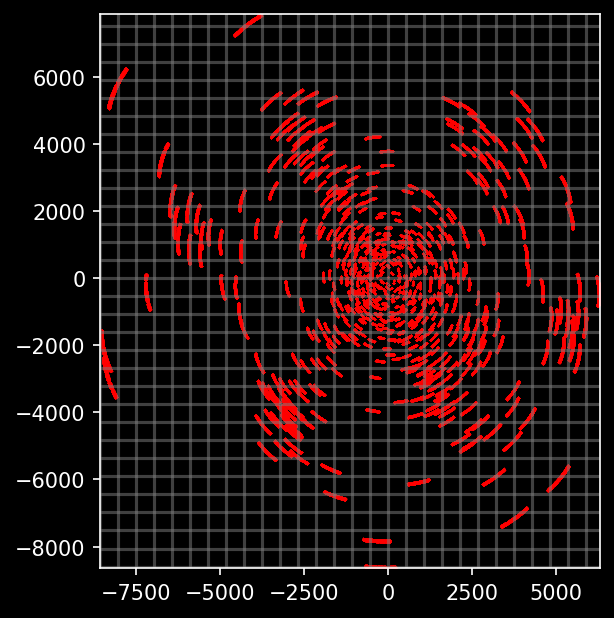

In [ ]:
plot_uv_coverage(u, v, grid = True)

In [43]:
def process_binstat(data, weight):
    y = list(zip(data, weight))
    out = np.empty(len(data), dtype = object)
    out[:] = y
    return out

data_real = process_binstat(vis_re, weight_)
data_imag = process_binstat(vis_imag, weight_)


In [44]:
bin_x = u_edges
bin_y = v_edges

def binned_mean(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.average(values, weights = w)

def binned_std(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(

vis_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (bin_y, bin_x), statistic = binned_mean)
vis_bin_img, _, _, _ = binned_statistic_2d(vv, uu, values = data_imag, bins = (bin_y, bin_x), statistic = binned_mean)
std_bin_re, _, _, _ = binned_statistic_2d(vv, uu, values = data_real, bins = (bin_y, bin_x), statistic = binned_std)
std_bin_img, _, _, _ = binned_statistic_2d(vv, uu, values = data_imag, bins = (bin_y, bin_x), statistic = binned_std)
counts, _, _, _ = binned_statistic_2d(vv, uu, values = weight_, bins = (bin_y, bin_x), statistic = "count")




In [45]:
# From object type to float
vis_bin_re = vis_bin_re.astype(float)
vis_bin_img = vis_bin_img.astype(float)
std_bin_re = std_bin_re.astype(float) 
std_bin_img = std_bin_img.astype(float)
counts = counts.astype(float)

# i.e. The sampling function where there is data in the uv plane
mask = counts>0 

# binned_stat outputs nans, we put everything to zero instead
vis_bin_re[~mask] = 0.
vis_bin_img[~mask] = 0.
std_bin_re[~mask] = 0.
std_bin_img[~mask] = 0.
counts[~mask] = 0.

std_bin_re /= (counts + 1)**0.5
std_bin_img /= (counts + 1)**0.5


# To compute the dirty image
vis_grid = np.fft.fftshift(vis_bin_re + 1j * vis_bin_img)

# For the inference, fftshift + flatten everything for the fft
vis_gridded_re = np.fft.fftshift(vis_bin_re).flatten()
vis_gridded_img = np.fft.fftshift(vis_bin_img).flatten()
std_gridded_re = np.fft.fftshift(std_bin_re).flatten()
std_gridded_img = np.fft.fftshift(std_bin_re).flatten()
S_grid = np.fft.fftshift(mask).flatten()


In [58]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = plt.imshow(dirty_image, origin = "lower", cmap = "magma")  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")

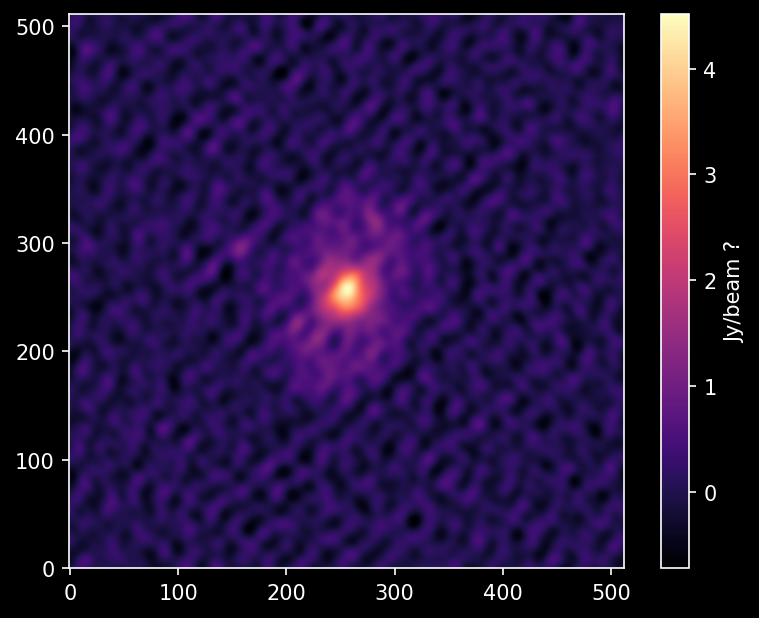

In [59]:
dirty_image = plot_dirty_image(vis_grid)

In [48]:
# Numpy to torch: 
S_cat = np.concatenate([S_grid, S_grid])
vis_gridded = np.concatenate([vis_gridded_re, vis_gridded_img])
std_gridded = np.concatenate([std_gridded_re, std_gridded_img])

S = torch.tensor(S_cat).to(device)
y = torch.tensor(vis_gridded, device = S.device)[S].to(device) * npix
sigma_y = torch.tensor(std_gridded, device = S.device)[S].to(device) * npix


In [34]:
print(f"Max, mean, min y: {y.max():.2g}, {y.min():.2g}, {y.mean():.2g}")
print(f"Max, mean, min sigma_y: {sigma_y.max():.2g}, {sigma_y.min():.2g}, {sigma_y.mean():.2g}")

Max, mean, min y: 82, -38, 0.67
Max, mean, min sigma_y: 14, 0, 0.66


In [49]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def link_function(x): 
    return (x+1) / 2 

def flip(x): 
    return x[:, ::-1]

In [50]:
def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

In [51]:
#sigma_y = 1e8 * torch.ones(len(y)).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x, t):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function(x) # map from model unit space to real unit space
    # Padding: 
    pad_size = int((npix - img_size)/2)
    #x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    x = noise_padding(x, pad = pad_size, sigma = sigma(t))
    vis_full = ft(torch.fft.fftshift(x)).flatten() 
    vis_sampled = vis_full
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled[S]


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x, t)
    var = sigma(t) **2 / 2  + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(y, x, t, sigma_y): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)), randomness = "different")(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(y, x, t, sigma_y) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(y, k, t, sigma_y)**2))**0.5)
print(score_posterior(k, t))

tensor(0.0215, device='cuda:0')
tensor([[ 0.0019, -0.0029, -0.0019,  ...,  0.0015, -0.0031, -0.0004]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [52]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,))

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return torch.flip(link_function(x_mean).reshape(num_samples, img_size, img_size), dims = (2,))

pred = 500
corr = 100
snr = 1e-2
num_samples = 1
samples = euler_sampler(num_samples = num_samples, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [01:53<00:00,  4.41it/s]


True


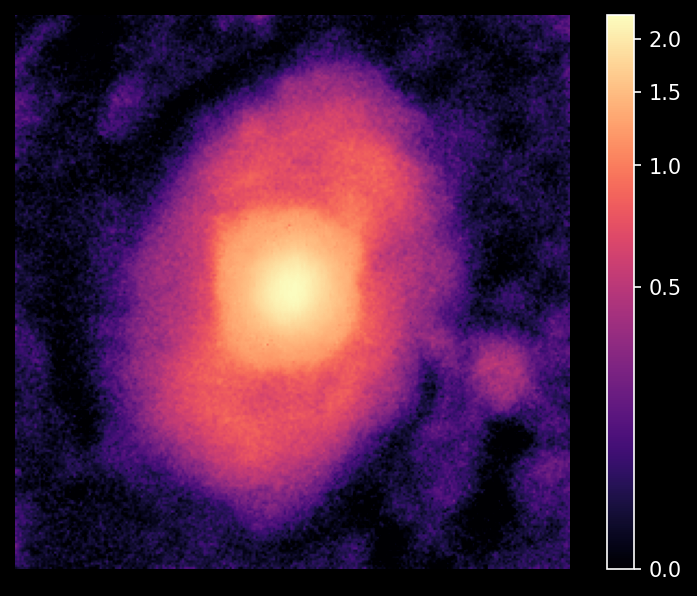

In [53]:
norm = True
save = False
n_images = samples.shape[0]
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{img_size}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{img_size}nonorm.jpeg"
        norm = None
    plt.imshow(samples[0].cpu(), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [ ]:
residuals = (y - model(samples))/sigma_y

In [27]:
sigma_y.mean()

tensor(3.4176e-07, dtype=torch.float64)

In [83]:
(std_gridded_re/(count+1)).mean()

3.2939683515150124e-07

In [84]:
vis_gridded_re.mean()

2.063231375540872e-05

In [7]:
def flip(x): 
    return x[:, ::-1]

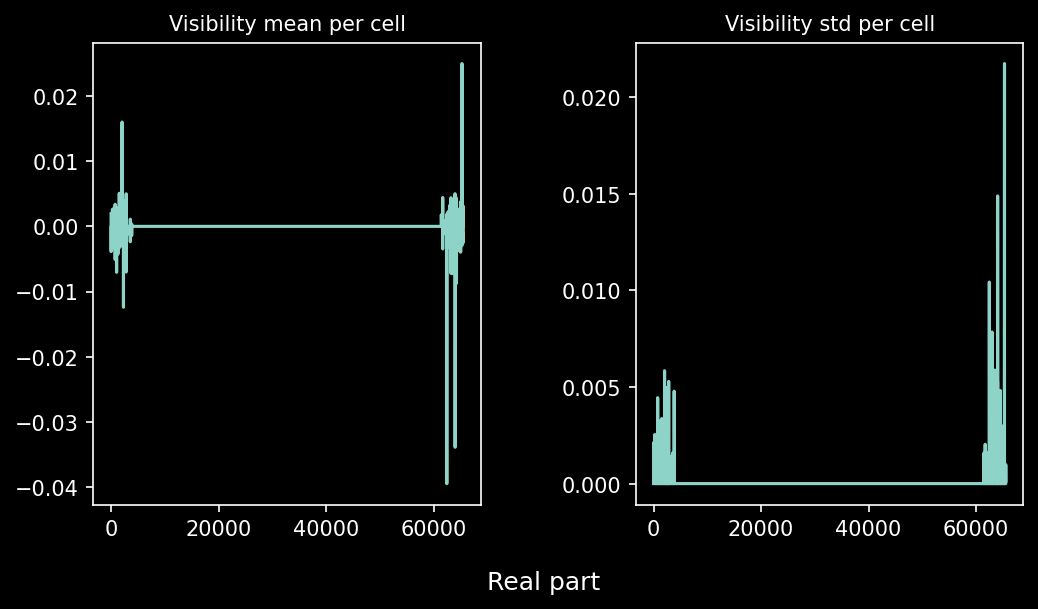

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (4*2, 4))
axs[0].plot(vis_gridded_img)
axs[0].set_title("Visibility mean per cell", size = 10)

axs[1].plot(std_gridded_img)
axs[1].set_title("Visibility std per cell", size = 10)

fig.suptitle("Imaginary part", y = 0.001)
plt.subplots_adjust(wspace = 0.4)

In [66]:
S_count = count>0.0
S_std = std_gridded_re.astype(bool)

In [67]:
S_std.min()

False

In [68]:
(S_count == S_std)

C:\Users\noedi\AppData\Local\Temp\ipykernel_12852\863845559.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (S_count == S_std)


False

In [75]:
S_count[0, 0]

False

In [76]:
np.where(S_count != np.fft.fftshift(S_std.reshape(img_size, img_size)))

(array([], dtype=int64), array([], dtype=int64))

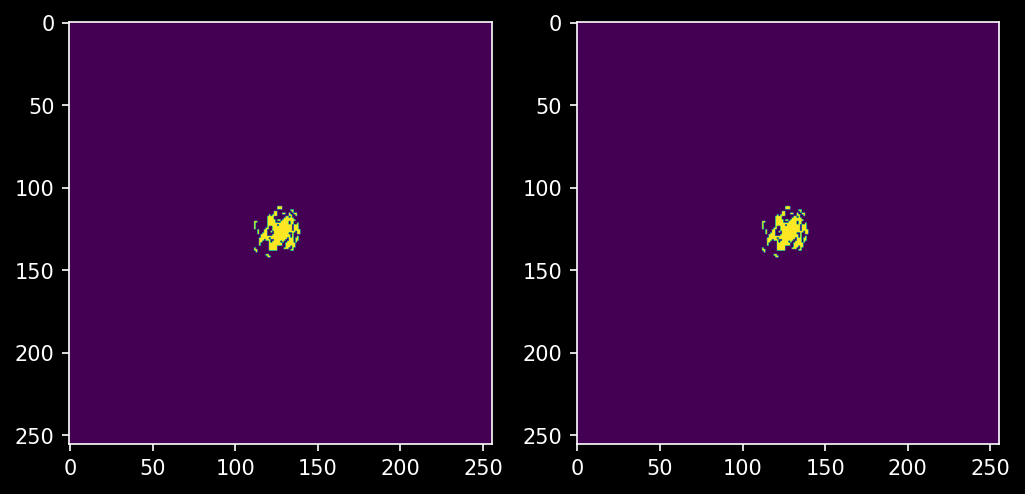

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

axs[0].imshow(S_count.reshape(img_size, img_size))
axs[1].imshow(np.fft.fftshift(S_std.reshape(img_size, img_size)))

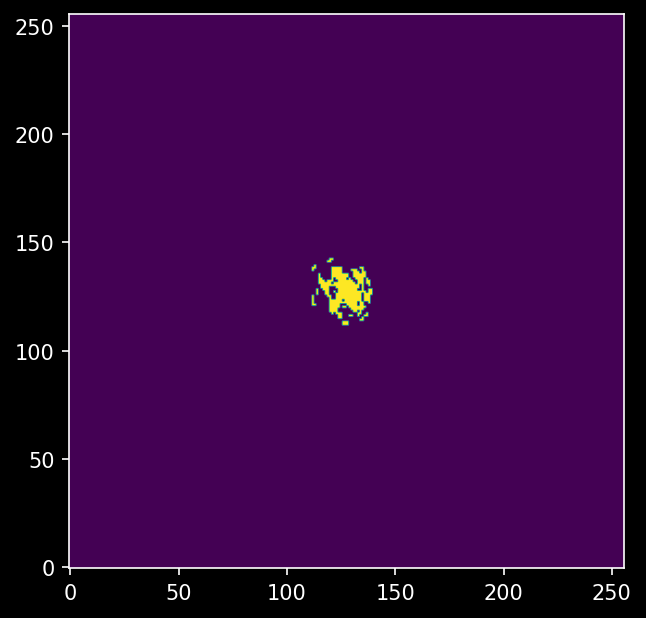

In [34]:
plt.imshow(np.fft.fftshift(S_grid.reshape(img_size, img_size)), origin = "lower")

In [23]:
vis_grid.real.max()

0.061462025318957836

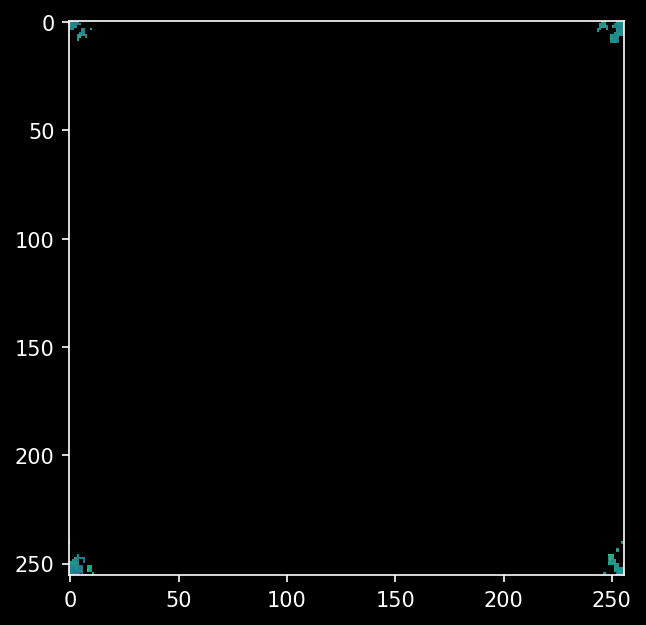

In [28]:
plt.imshow(std_gridded_re.reshape(img_size, img_size))

In [41]:
vis_grid.mean()

(2.063231375540872e-05-1.4509849062735517e-06j)

In [45]:
(std_gridded_re/ (count.flatten() + 1)).mean()

0.00035093002704310967

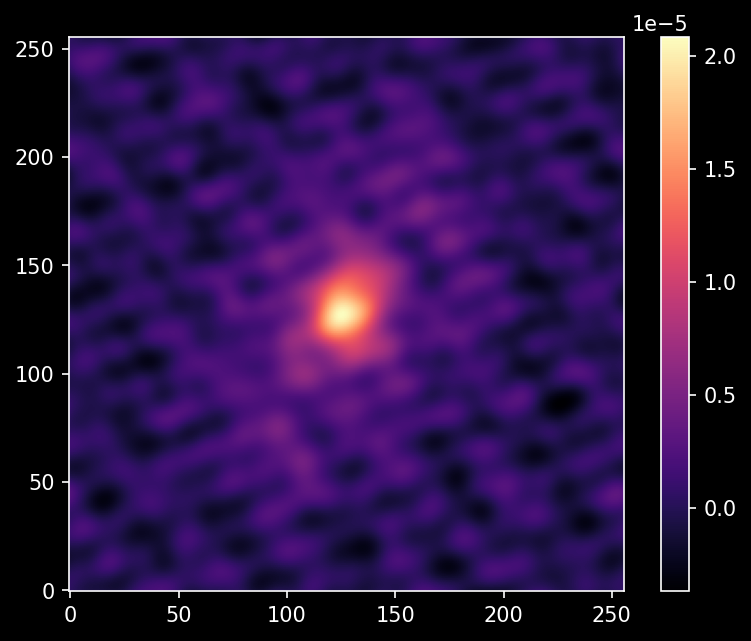

In [36]:
dirty_image = flip(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(vis_grid))))
plt.imshow(dirty_image.real, cmap = "magma", origin = "lower")
plt.colorbar()